In [254]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(1)

%matplotlib inline

## Task 1a

In [255]:
# Load the image
image1 = cv2.imread('./stitching/1.jpg')
image2 = cv2.imread('./stitching/2.jpg')

In [256]:
# Convert the training image to RGB
rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [257]:
# Convert the training image to gray scale
gray1 = cv2.cvtColor(rgb1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(rgb2, cv2.COLOR_RGB2GRAY)

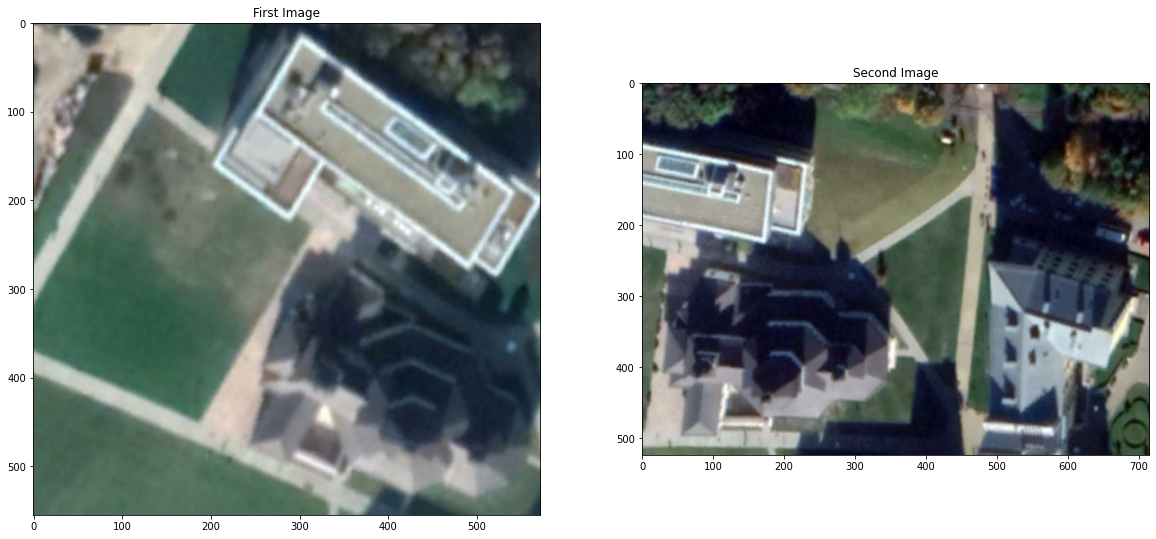

In [258]:
# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("First Image")
plots[0].imshow(rgb1)

plots[1].set_title("Second Image")
plots[1].imshow(rgb2);

In [259]:
def detectAndDescribe(image, method='orb'):
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)

    return (kps, features)

1. A **keypoint** (or interest point) is defined by some particular image\
intensities “around” it, such as a corner. It can be used for deriving a **descriptor**\
2. A descriptor is a **finite vector which summarizes properties for the
keypoint**\
3. Keypoint and descriptor together define a **feature**

In [260]:
def displayAngles(cp_rgb1, cp_rgb2, keyp1, keyp2):
    # detect angles
    cv2.drawKeypoints(gray1, keyp1, cp_rgb1, color = (0, 255, 0))
    cv2.drawKeypoints(gray2, keyp2, cp_rgb2, color = (0, 255, 0))

    # Display image with and without keypoints size
    fx, plots = plt.subplots(1, 2, figsize=(20,10))
    plots[0].set_title("Keypoints 1")
    plots[0].imshow(cp_rgb1, cmap='gray')

    plots[1].set_title("Keypoints 2")
    plots[1].imshow(cp_rgb2, cmap='gray');
    plt.show()

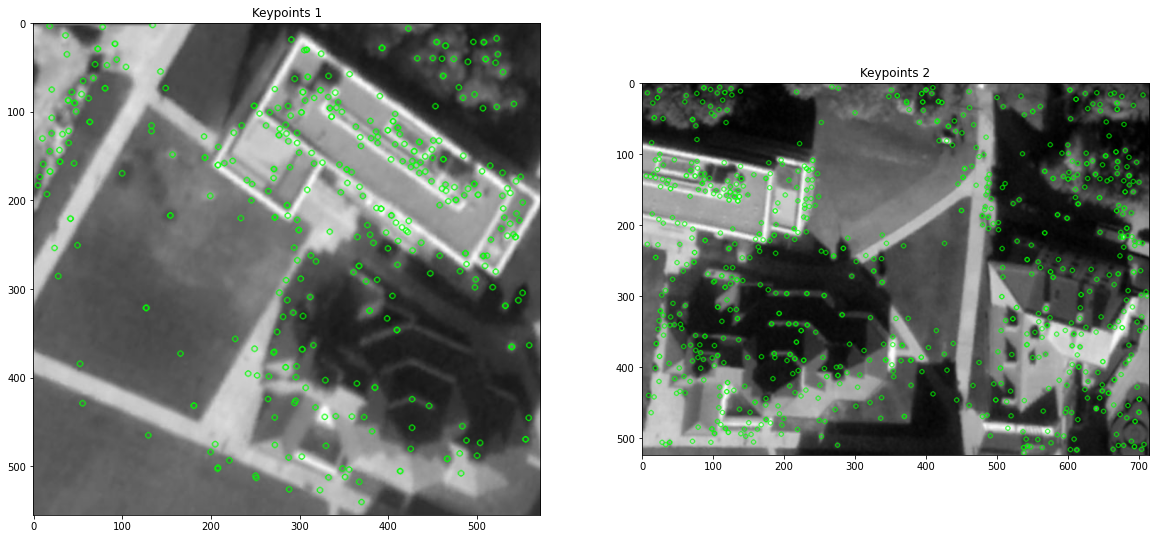

In [261]:
keyp1_sift, desc1_sift = detectAndDescribe(rgb1, 'sift')
keyp2_sift, desc2_sift = detectAndDescribe(rgb2, 'sift')

displayAngles(np.copy(rgb1), np.copy(rgb2), keyp1_sift, keyp2_sift)

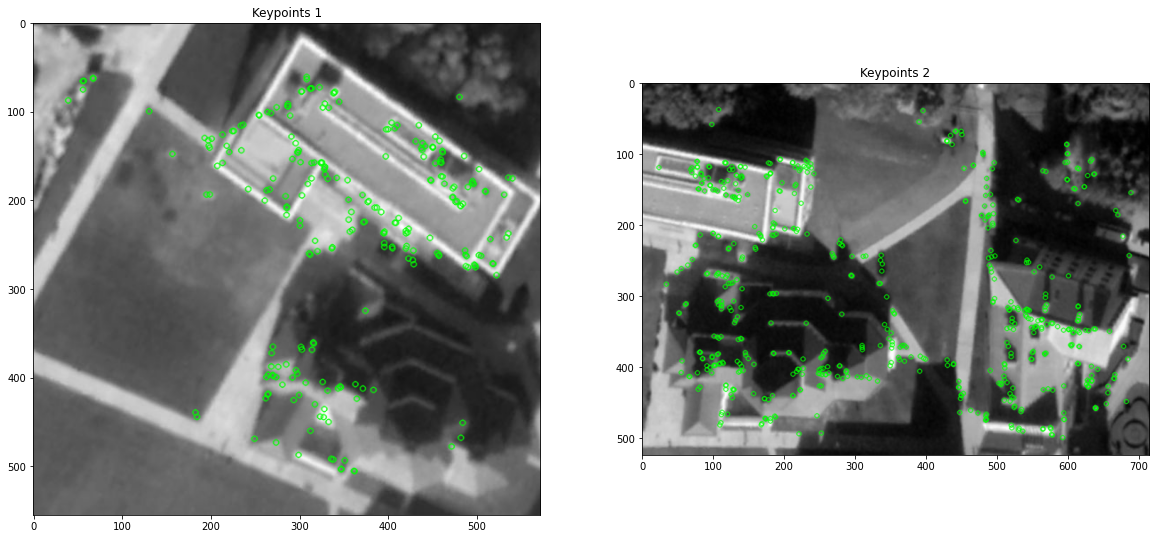

In [262]:
brisk_keyp1, brisk_desc1 = detectAndDescribe(rgb1, 'brisk')
brisk_keyp2, brisk_desc2 = detectAndDescribe(rgb2, 'brisk')

displayAngles(np.copy(rgb1), np.copy(rgb2), brisk_keyp1, brisk_keyp2)

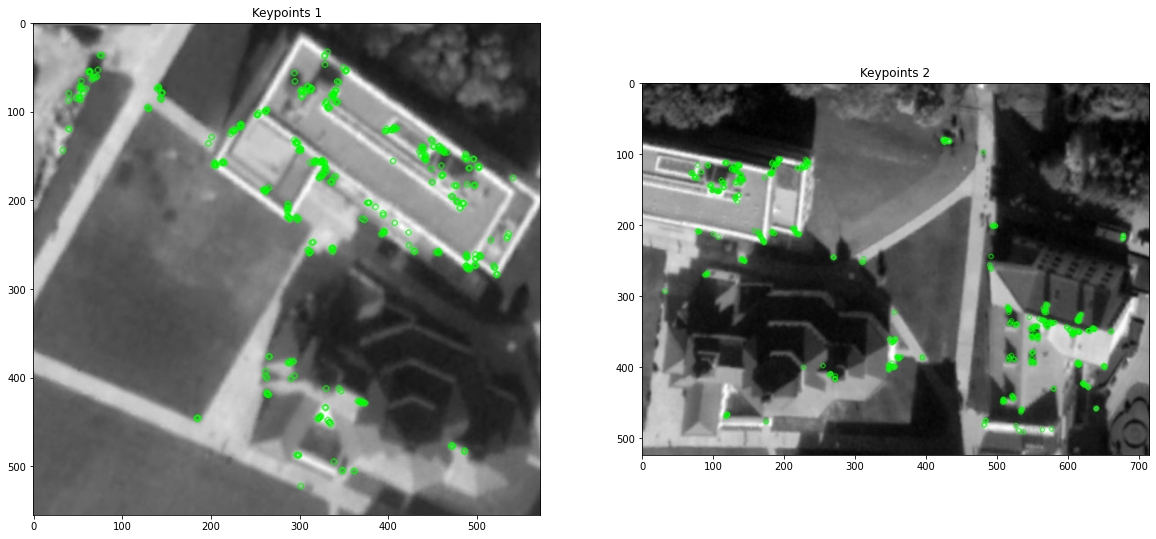

In [263]:
orb_keyp1, orb_desc1 = detectAndDescribe(rgb1)
orb_keyp2, orb_desc2 = detectAndDescribe(rgb2)

displayAngles(np.copy(rgb1), np.copy(rgb2), orb_keyp1, orb_keyp2)

In [264]:
def createMatcher(method, crossCheck=True):
    if method == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

If crossCheck is **True**, the result is more robust. It checks each keypoint (corner), to have two-way connection, from **f1** to **f2** and from **f2** to **f1**.

In [265]:
def knnMatcher(method, desc1, desc2, ratio=0.75):
    bf = createMatcher(method, crossCheck=False)
    knn_matches = bf.knnMatch(desc1, desc2, k=2)
    print("Raw matches (KNN):", len(knn_matches))
    
    # to filter the matches
    matches = []
    # loop over the arw knn matches
    for m,n in knn_matches:
        # ensure the distance is within a certain ratio of each
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [266]:
def bfMatcher(method, desc1, desc2):
    # as True -> matches are already filtered
    bf = createMatcher(method, crossCheck=True)
    bf_matches = bf.match(desc1, desc2)
    
    matches = sorted(bf_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(matches))
    return matches

### Sift KNN

Raw matches (KNN): 806


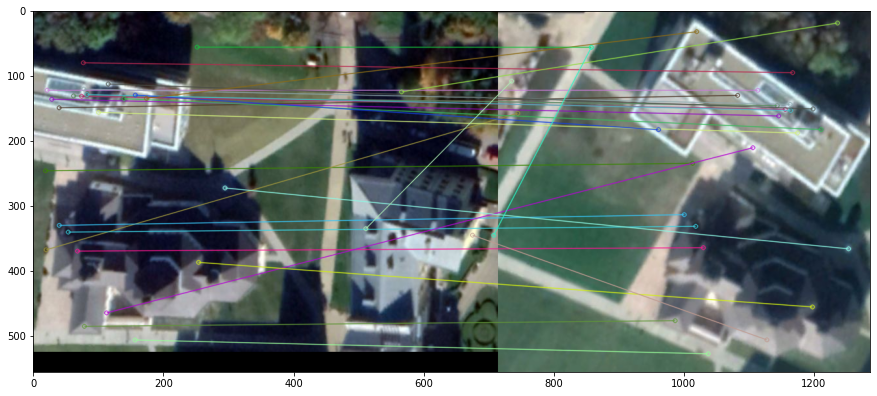

In [267]:
sift_matches = knnMatcher('sift', desc2_sift, desc1_sift, 0.75)
sift_match_img = cv2.drawMatches(rgb2, keyp2_sift, rgb1, keyp1_sift, sift_matches,
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.imshow(sift_match_img)
plt.show();

### Brisk KNN

Raw matches (KNN): 579


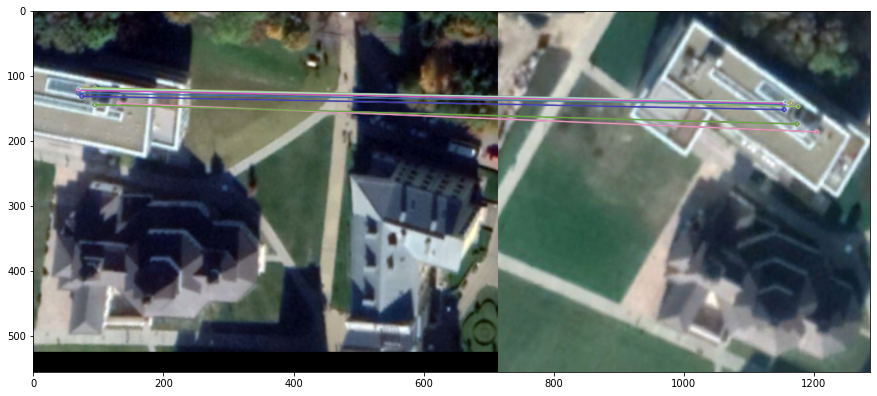

In [272]:
brisk_matches_knn = knnMatcher('brisk', brisk_desc2, brisk_desc1, 0.57)
brisk_match_img = cv2.drawMatches(rgb2, brisk_keyp2, rgb1, brisk_keyp1, np.random.choice(brisk_matches_knn, 100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.imshow(brisk_match_img)
plt.show();

### Brisk Brute Force

Raw matches (Brute force): 102


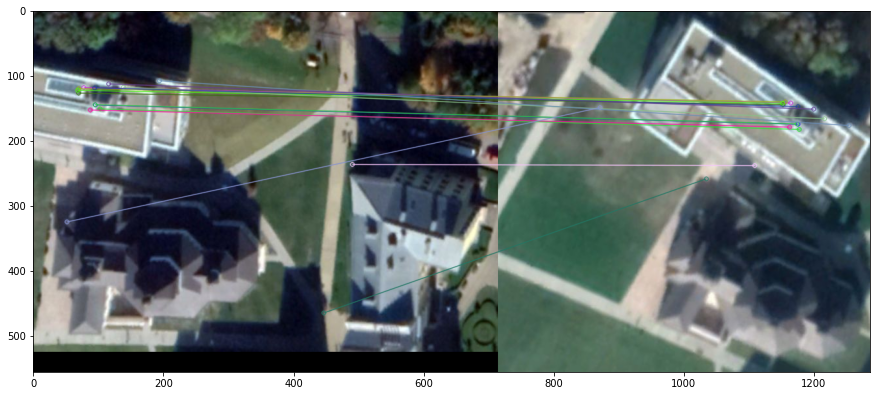

In [273]:
brisk_matches_bf = bfMatcher('brisk', brisk_desc2, brisk_desc1)
brisk_match_img = cv2.drawMatches(rgb2, brisk_keyp2, rgb1, brisk_keyp1, brisk_matches_bf[:15],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.imshow(brisk_match_img)
plt.show();

### ORB KNN

Raw matches (KNN): 500


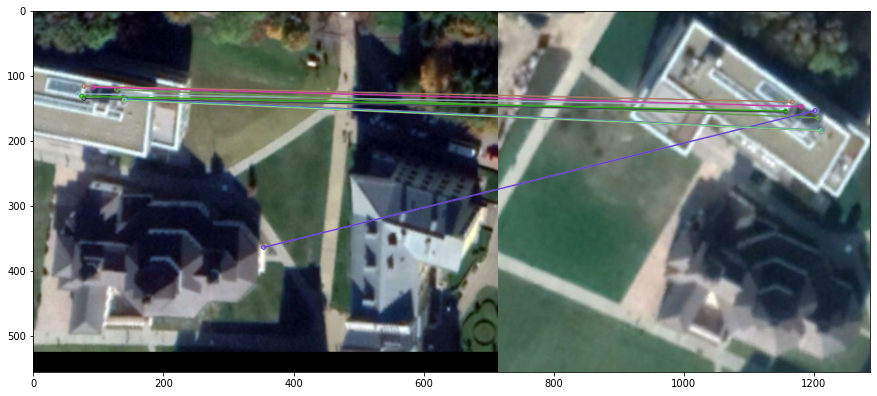

In [311]:
orb_matches_knn = knnMatcher('orb',  orb_desc2, orb_desc1, 0.67)
orb_match_img = cv2.drawMatches(rgb2, orb_keyp2, rgb1, orb_keyp1, np.random.choice(orb_matches_knn, 100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.imshow(orb_match_img)
plt.show();

### ORB Brute Force

Raw matches (Brute force): 127


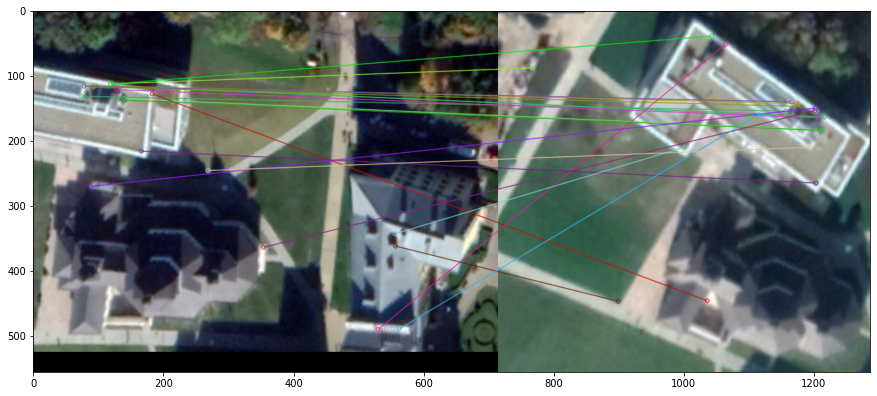

In [310]:
orb_matches_bf = bfMatcher('orb', orb_desc2, orb_desc1)
orb_match_img = cv2.drawMatches(rgb2, orb_keyp2, rgb1, orb_keyp1, orb_matches_bf[:20],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.imshow(orb_match_img)
plt.show();

### Conclusions:
The best performance we get from **BRISK** and **ORB**.

## Task 1b and 1c

In [296]:
# convert the keypoints to numpy arrays
def applyHomography(keyp1, desc1, keyp2, desc2, matches, homo_thresh):
    
    # extract the matched keypoints
    src_pts  = np.float32([keyp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts  = np.float32([keyp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    ## find homography matrix and do perspective transform
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, homo_thresh)
    return matches, M, mask

### BRISK BF, find Homography

In [307]:
M = applyHomography(brisk_keyp2, brisk_desc2,\
                    brisk_keyp1, brisk_desc1,\
                    brisk_matches_bf, homo_thresh=4)
if M is None:
    print("Error with Homography.")
matches, H, status = M
print(H)

[[ 1.04001447e+00 -2.73926348e-01  4.26080051e+02]
 [ 1.83442542e-01  1.30082111e+00 -2.13290588e+01]
 [-6.17238877e-04  8.39008177e-04  1.00000000e+00]]


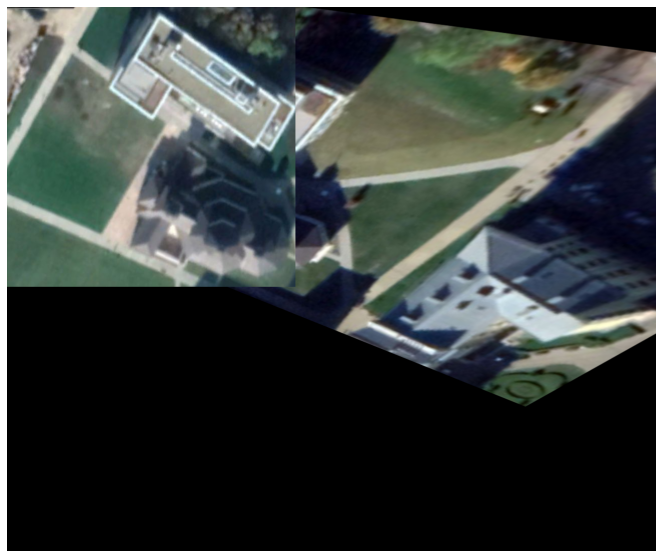

In [308]:
# Apply panorama correction
# train img = rgb2
# guery = rgb1
width = rgb2.shape[1] + rgb1.shape[1]
height = rgb2.shape[0] + rgb1.shape[0]

result = cv2.warpPerspective(rgb2, H, (width, height))
result[0:rgb1.shape[0], 0:rgb1.shape[1]] = rgb1

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

### ORB BF, find Homography

In [314]:
M = applyHomography(orb_keyp2, orb_desc2,\
                    orb_keyp1, orb_desc1,\
                    orb_matches_bf, homo_thresh=4)
if M is None:
    print("Error with Homography.")
(matches, H, status) = M
print(H)

[[ 9.64640583e-01 -5.41021812e-01  4.33728413e+02]
 [ 4.33742888e-01  8.29365249e-01  8.86023296e+00]
 [ 2.08900006e-04 -2.32487190e-04  1.00000000e+00]]


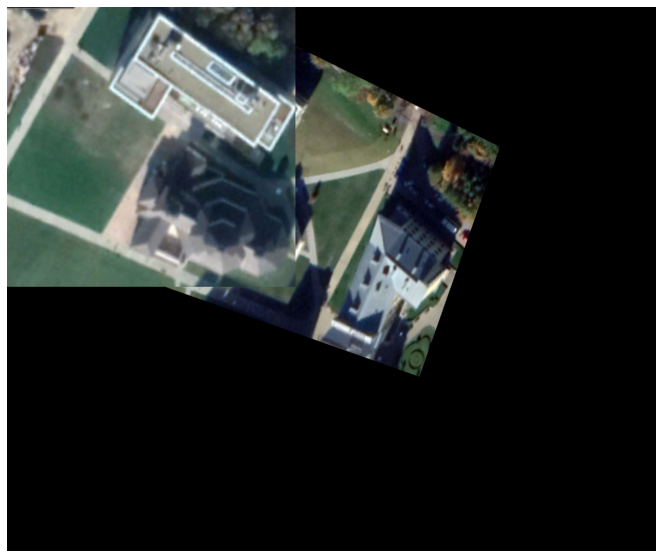

In [315]:
# Apply panorama correction
# train img = rgb2
# guery = rgb1
result = cv2.warpPerspective(rgb2, H, (width, height))
result[0:rgb1.shape[0], 0:rgb1.shape[1]] = rgb1

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()